In [1]:
import json
import pathlib

import pandas as pd
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

DATA_DIR = pathlib.Path('../data')

## Optimal

In [2]:
with (DATA_DIR / 'boardOptimals.json').open() as f:
    optimal = json.load(f)

## Load data

In [3]:
def load_data(filepath):
    with open(filepath) as f:
        return json.load(f)

In [4]:
def to_record(experiment):
    return {
        'board_id': experiment['gs']['boardID'],
        'ticks': experiment['gs']['tick'],
        'impossible_actions': experiment['gs']['impossibleActionCount'],
        'first_winner_tick': experiment['gs']['firstWinnerTick'],
        'heuristic': experiment['agentsParams'][0]['heuristic_method'],
    }

In [5]:
optimal

{'boards': [{'boardID': 0, 'tick': 9, 'firstWinnerTick': 9},
  {'boardID': 1, 'tick': 11, 'firstWinnerTick': 8},
  {'boardID': 2, 'tick': 28, 'firstWinnerTick': 17},
  {'boardID': 3, 'tick': 10, 'firstWinnerTick': 9},
  {'boardID': 4, 'tick': 15, 'firstWinnerTick': 8},
  {'boardID': 5, 'tick': 10, 'firstWinnerTick': 10},
  {'boardID': 6, 'tick': 10, 'firstWinnerTick': 8}]}

In [6]:
df = pd.DataFrame.from_records(to_record(x) for x in load_data(DATA_DIR / '200_ticks.json'))
df['success'] = df['ticks'] < 200
df['second_winner_lag'] = df['ticks'] - df['first_winner_tick']
df['solo'] = (df['heuristic'] % 2).astype(bool)
df['binary'] = df['heuristic'] < 3

def is_optimal(experiment):
    for board in optimal['boards']:
        if board['boardID'] == experiment['board_id']:
            return experiment['ticks'] <= board['tick']
    raise AssertionError("Shouldn't happen")

df['optimal'] = df.apply(is_optimal, axis=1)

## Success percentage

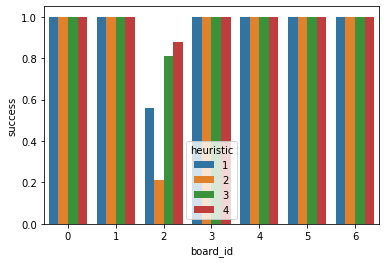

In [7]:
sns.barplot(
    y='success',
    x='board_id',
    hue='heuristic',
    data=df.groupby(['board_id', 'heuristic'])['success'].mean().reset_index(),
)

## Analysis including failures

### Ticks

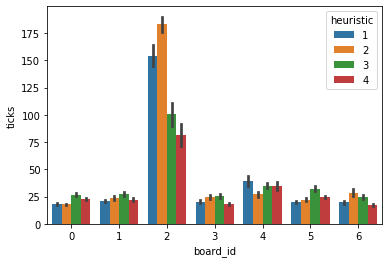

In [8]:
sns.barplot(
    y='ticks',
    x='board_id',
    hue='heuristic',
    data=df,
)

### Impossible actions

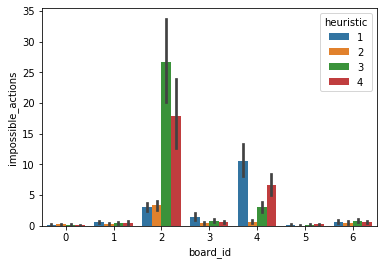

In [9]:
sns.barplot(
    y='impossible_actions',
    x='board_id',
    hue='heuristic',
    data=df,
)

### 2nd winner lag

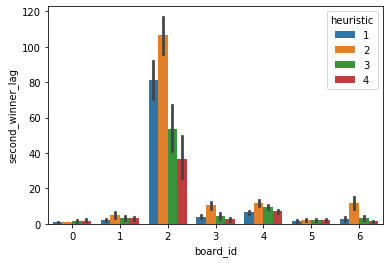

In [10]:
sns.barplot(
    y='second_winner_lag',
    x='board_id',
    hue='heuristic',
    data=df,
)

## Successfull runs only

### Ticks

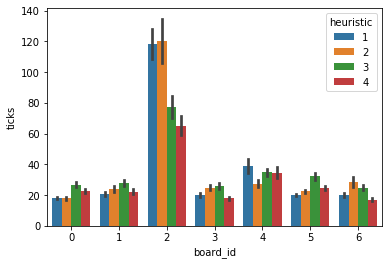

In [11]:
sns.barplot(
    y='ticks',
    x='board_id',
    hue='heuristic',
    data=df[df['success']],
)

### Impossible actions

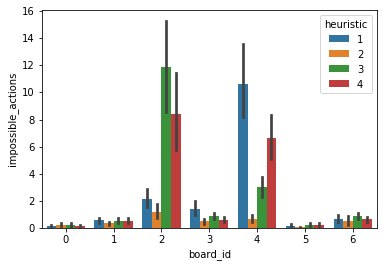

In [12]:
sns.barplot(
    y='impossible_actions',
    x='board_id',
    hue='heuristic',
    data=df[df['success']],
)

### 2nd winner lag

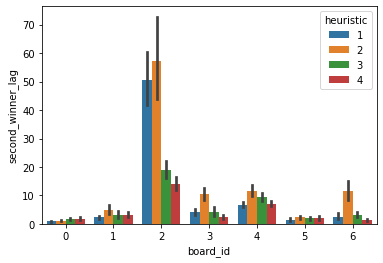

In [13]:
sns.barplot(
    y='second_winner_lag',
    x='board_id',
    hue='heuristic',
    data=df[df['success']],
)

## Is the number of ticks different between solo and joint

In [14]:
stats.ttest_ind(df['ticks'][df['solo'] == True], df['ticks'][df['solo'] == False])

Ttest_indResult(statistic=0.6675240298290025, pvalue=0.5044925157552055)

## Percentage optimal

In [15]:
df['optimal'].mean()

0.002142857142857143

In [16]:
df[df['ticks'] < 100].groupby('heuristic').mean()

,board_id,first_winner_tick,impossible_actions,ticks,success,second_winner_lag,solo,binary,optimal
heuristic,,,,,,,,,
1,3.123779,20.431596,1.786645,23.908795,1.0,3.477199,1.0,1.0,0.001629
2,3.148515,17.561056,0.374587,24.701320,1.0,7.140264,0.0,1.0,0.001650
3,3.062215,26.324734,1.216995,31.484067,1.0,5.159332,1.0,0.0,0.003035
4,3.035503,22.522189,1.683432,26.865385,1.0,4.343195,0.0,0.0,0.002959


# ANOVAAAAAAAAA!

### ticks ~ heuristic * board

In [17]:
lm = ols('ticks ~ C(heuristic) * C(board_id)', data=df).fit()

In [18]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  ticks   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     384.7
Date:                Thu, 13 Jun 2019   Prob (F-statistic):               0.00
Time:                        13:06:12   Log-Likelihood:                -12469.
No. Observations:                2800   AIC:                         2.499e+04
Df Residuals:                    2772   BIC:                         2.516e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             18.2300      2.089      8.727      0.000      14.134      22.326
C(heuristic)[T.2]                     -0.3500      2.954     -0.118      0.906      -6.143       5.443
C(heuristic)[T.3]                      8.6200      2.954      2.918      0.004       2.827      14.413
C(heuristic)[T.4]                      4.5800      2.954      1.550      0.121      -1.213      10.373
C(board_id)[T.1]                       2.5100      2.954      0.850      0.396      -3.283       8.303
C(board_id)[T.2]                     136.0500      2.954     46.052      0.000     130.257     141.843
C(board_id)[T.3]                       1.8600      2.954      0.630      0.529      -3.933       7.653
C(board_id)[T.4]                      20.7900      2.954      7.037      0.000      14.997      26.583
C(board_id)[T.5]                       1.8000      2.954      0.609      0.542      -3.993       7.593
C(board_id)[T.6]                       1.5700      2.954      0.531      0.595      -4.223       7.363
C(heuristic)[T.2]:C(board_id)[T.1]     3.5300      4.178      0.845      0.398      -4.662      11.722
C(heuristic)[T.3]:C(board_id)[T.1]    -1.5800      4.178     -0.378      0.705      -9.772       6.612
C(heuristic)[T.4]:C(board_id)[T.1]    -2.9500      4.178     -0.706      0.480     -11.142       5.242
C(heuristic)[T.2]:C(board_id)[T.2]    29.3800      4.178      7.032      0.000      21.188      37.572
C(heuristic)[T.3]:C(board_id)[T.2]   -62.3900      4.178    -14.933      0.000     -70.582     -54.198
C(heuristic)[T.4]:C(board_id)[T.2]   -77.4700      4.178    -18.542      0.000     -85.662     -69.278
C(heuristic)[T.2]:C(board_id)[T.3]     5.2200      4.178      1.249      0.212      -2.972      13.412
C(heuristic)[T.3]:C(board_id)[T.3]    -2.8900      4.178     -0.692      0.489     -11.082       5.302
C(heuristic)[T.4]:C(board_id)[T.3]    -6.7600      4.178     -1.618      0.106     -14.952       1.432
C(heuristic)[T.2]:C(board_id)[T.4]   -11.4400      4.178     -2.738      0.006     -19.632      -3.248
C(heuristic)[T.3]:C(board_id)[T.4]   -12.6200      4.178     -3.021      0.003     -20.812      -4.428
C(heuristic)[T.4]:C(board_id)[T.4]    -8.9900      4.178     -2.152      0.032     -17.182      -0.798
C(heuristic)[T.2]:C(board_id)[T.5]     2.7000      4.178      0.646      0.518      -5.492      10.892
C(heuristic)[T.3]:C(board_id)[T.5]     3.5200      4.178      0.843      0.400      -4.672      11.712
C(heuristic)[T.4]:C(board_id)[T.5]     0.0600      4.178      0.014      0.989      -8.132       8.252
C(heuristic)[T.2]:C(board_id)[T.6]     9.1300      4.178      2.185      0.029       0.938      17.322
C(heuristic)[T.3]:C(board_id)[T.6]    -3.6600      4.178     -0.876      0.381     -11.852      

In [19]:
sm.stats.anova_lm(lm, typ=2)

,sum_sq,df,F,PR(>F)
C(heuristic),8.599125e+04,3.0,65.683911,5.009681e-41
C(board_id),3.830049e+06,6.0,1462.780218,0.000000e+00
C(heuristic):C(board_id),6.163128e+05,18.0,78.461156,8.190075e-232
Residual,1.209671e+06,2772.0,NaN,NaN


In [20]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  ticks   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     384.7
Date:                Thu, 13 Jun 2019   Prob (F-statistic):               0.00
Time:                        13:06:12   Log-Likelihood:                -12469.
No. Observations:                2800   AIC:                         2.499e+04
Df Residuals:                    2772   BIC:                         2.516e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             18.2300      2.089      8.727      0.000      14.134      22.326
C(heuristic)[T.2]                     -0.3500      2.954     -0.118      0.906      -6.143       5.443
C(heuristic)[T.3]                      8.6200      2.954      2.918      0.004       2.827      14.413
C(heuristic)[T.4]                      4.5800      2.954      1.550      0.121      -1.213      10.373
C(board_id)[T.1]                       2.5100      2.954      0.850      0.396      -3.283       8.303
C(board_id)[T.2]                     136.0500      2.954     46.052      0.000     130.257     141.843
C(board_id)[T.3]                       1.8600      2.954      0.630      0.529      -3.933       7.653
C(board_id)[T.4]                      20.7900      2.954      7.037      0.000      14.997      26.583
C(board_id)[T.5]                       1.8000      2.954      0.609      0.542      -3.993       7.593
C(board_id)[T.6]                       1.5700      2.954      0.531      0.595      -4.223       7.363
C(heuristic)[T.2]:C(board_id)[T.1]     3.5300      4.178      0.845      0.398      -4.662      11.722
C(heuristic)[T.3]:C(board_id)[T.1]    -1.5800      4.178     -0.378      0.705      -9.772       6.612
C(heuristic)[T.4]:C(board_id)[T.1]    -2.9500      4.178     -0.706      0.480     -11.142       5.242
C(heuristic)[T.2]:C(board_id)[T.2]    29.3800      4.178      7.032      0.000      21.188      37.572
C(heuristic)[T.3]:C(board_id)[T.2]   -62.3900      4.178    -14.933      0.000     -70.582     -54.198
C(heuristic)[T.4]:C(board_id)[T.2]   -77.4700      4.178    -18.542      0.000     -85.662     -69.278
C(heuristic)[T.2]:C(board_id)[T.3]     5.2200      4.178      1.249      0.212      -2.972      13.412
C(heuristic)[T.3]:C(board_id)[T.3]    -2.8900      4.178     -0.692      0.489     -11.082       5.302
C(heuristic)[T.4]:C(board_id)[T.3]    -6.7600      4.178     -1.618      0.106     -14.952       1.432
C(heuristic)[T.2]:C(board_id)[T.4]   -11.4400      4.178     -2.738      0.006     -19.632      -3.248
C(heuristic)[T.3]:C(board_id)[T.4]   -12.6200      4.178     -3.021      0.003     -20.812      -4.428
C(heuristic)[T.4]:C(board_id)[T.4]    -8.9900      4.178     -2.152      0.032     -17.182      -0.798
C(heuristic)[T.2]:C(board_id)[T.5]     2.7000      4.178      0.646      0.518      -5.492      10.892
C(heuristic)[T.3]:C(board_id)[T.5]     3.5200      4.178      0.843      0.400      -4.672      11.712
C(heuristic)[T.4]:C(board_id)[T.5]     0.0600      4.178      0.014      0.989      -8.132       8.252
C(heuristic)[T.2]:C(board_id)[T.6]     9.1300      4.178      2.185      0.029       0.938      17.322
C(heuristic)[T.3]:C(board_id)[T.6]    -3.6600      4.178     -0.876      0.381     -11.852      